# Playground for normalizing flows

In [1]:
# Show plots inline, and load main getdist plot module and samples class
#Change
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1
# import libraries:
import sys, os
here = './'
temp_path = os.path.realpath(os.path.join(os.getcwd(), here+'tensiometer/'))
sys.path.insert(0, temp_path)
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False
import scipy
import matplotlib.pyplot as plt
import IPython
from IPython.display import Markdown
import numpy as np
import seaborn as sns
# import the tensiometer tools that we need:
from tensiometer import utilities
from tensiometer import gaussian_tension
from tensiometer import mcmc_tension

In [2]:
# load the chains (remove no burn in since the example chains have already been cleaned):
chains_dir = here+'/tensiometer/test_chains/'
# the data chain:
settings = {'ignore_rows':0, 'smooth_scale_1D':0.3, 'smooth_scale_2D':0.3}
chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True, settings=settings)
#chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'Planck18TTTEEE', no_cache=True, settings=settings)
# the prior chain:
prior_chain = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'prior', no_cache=True, settings=settings)

In [3]:
# select parameters:
param_names = ['omegam', 'sigma8']

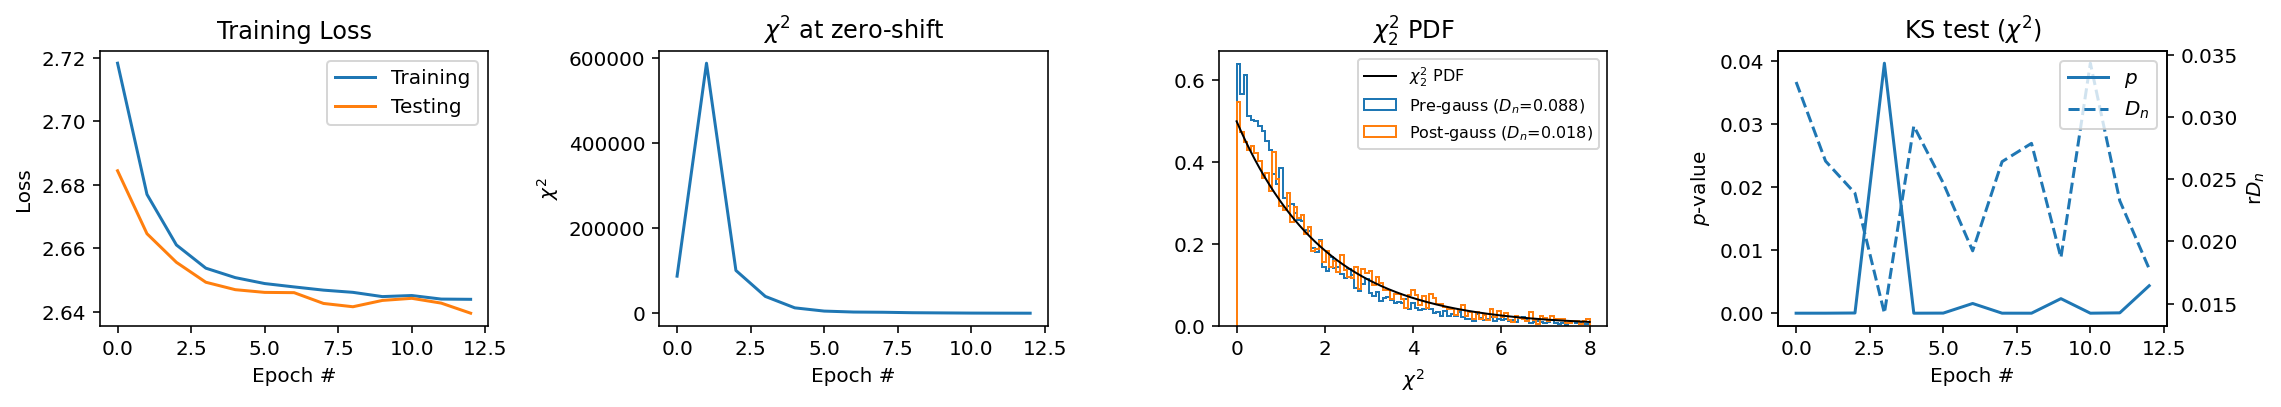

Epoch 14/40
 70/128 [===============>..............] - ETA: 1s - loss: 2.6432

KeyboardInterrupt: 

In [4]:
# define the flow:
flow_callback = mcmc_tension.DiffFlowCallback(chain, param_names=param_names, feedback=1, learning_rate=0.01)

# train:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [ReduceLROnPlateau()]

batch_size = 8192
epochs = 40
steps_per_epoch = 128

flow_callback.train(batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)

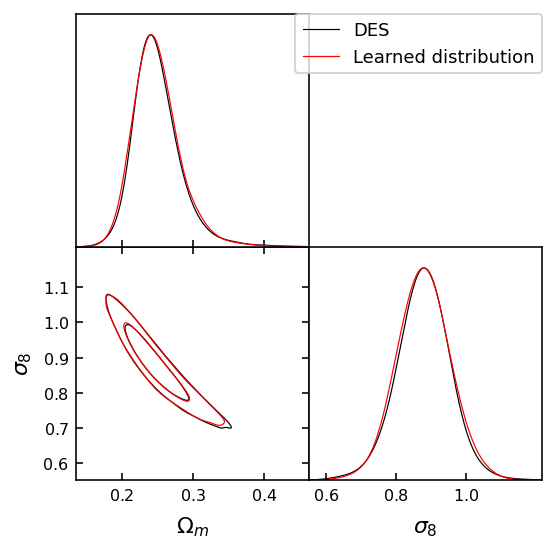

In [9]:
# plot learned distribution:
N = 10000
X_sample = np.array(flow_callback.dist_learned.sample(N))
flow_chain = MCSamples(samples=X_sample, names=param_names, label='Learned distribution')

g = plots.get_subplot_plotter()
g.triangle_plot([chain, flow_chain], params=param_names, filled=False)

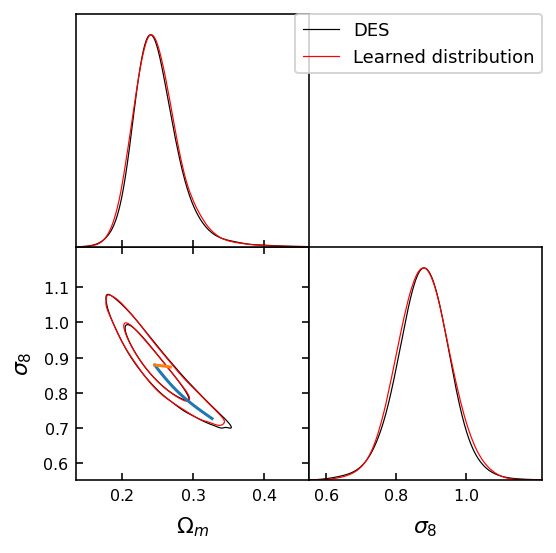

In [11]:
# plot principal axes:
x = np.linspace(0.0, 2.0, 100)
dir_1 = flow_callback.Z2X_bijector(np.vstack((x, np.zeros(len(x)))).T.astype(np.float32))
dir_2 = flow_callback.Z2X_bijector(np.vstack((np.zeros(len(x)), x)).T.astype(np.float32))
g = plots.get_subplot_plotter()
g.triangle_plot([chain, flow_chain], params=param_names, filled=False)
ax = g.subplots[1, 0]
ax.plot(dir_1[:, 0], dir_1[:, 1])
ax.plot(dir_2[:, 0], dir_2[:, 1])